In [1]:
from lib import *
import pandas as pd
import matplotlib.pyplot as plt

pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')


#dfs = load_data_bq()
dfs = load_data_db()

df_contratos = dfs
df_contratos = df_contratos["dias_agenciados"]

Conexão estabelecida com sucesso!


In [2]:
df_eventos = pd.read_csv(
    "data/Clientes Estratégicos - B2B x Conteúdo Personalizado(base).csv", 
    sep=";", 
    encoding="latin1"  # or "cp1252"
)


df_eventos.columns = ['cnpj', 'ID', 'NOME TRANSPORTADORA(S)', 'Status', 'Tier', 'CONTROLE',
       'CONTEÚDO PERSONALIZADO', 'TELEMETRIA', 'CAVALEIRO', 'TIPO',
       'DIAS DE CONTRATO', 'Data Telemetria', 'Data Conteúdo Personalizado']


In [3]:
df_eventos = df_eventos.fillna(0)

In [4]:
import pandas as pd
import re
df = df_eventos

# Função para limpar a string e converter para lista de inteiros, ignorando itens inválidos
def parse_ids(s):
    # Remove colchetes se houver
    s_clean = re.sub(r'[\[\]]', '', s)
    result = []
    for item in s_clean.split(','):
        item_str = item.strip()
        try:
            result.append(int(item_str))
        except ValueError:
            # Ignora o item se não puder ser convertido para inteiro (ex.: '#N/D')
            continue
    return result

# Cria uma nova coluna com a lista de IDs
df['ID_list'] = df['ID'].apply(parse_ids)

# Explode a coluna 'ID_list' para transformar cada ID em uma nova linha
df_exploded = df.explode('ID_list')

# Descarta a coluna original 'ID' para evitar duplicidade
df_exploded = df_exploded.dropna(axis=0)
df_exploded = df_exploded.drop(columns=['ID'])

# Renomeia a coluna explode para "ID"
df_exploded = df_exploded.rename(columns={'ID_list': 'ID'})

# Converte a coluna de ID para inteiro (agora todos os valores são provenientes da lista)
df_exploded['ID'] = df_exploded['ID'].astype(int)



df_contratos = df_contratos.merge(df_exploded, left_on="company_id", right_on="ID")
# Converter a coluna created_at para datetime, se já não estiver no formato adequado
df_contratos['created_at'] = pd.to_datetime(df_contratos['created_at'])

# Criar as novas colunas com o mês e o ano
df_contratos['mes'] = df_contratos['created_at'].dt.month
df_contratos['ano'] = df_contratos['created_at'].dt.year
df_contratos['dia'] = df_contratos['created_at'].dt.day
# Exibe o DataFrame resultante
df_contratos.head()


,created_at,company_id,contract_days,cnpj,NOME TRANSPORTADORA(S),Status,Tier,CONTROLE,CONTEÚDO PERSONALIZADO,TELEMETRIA,CAVALEIRO,TIPO,DIAS DE CONTRATO,Data Telemetria,Data Conteúdo Personalizado,ID,mes,ano,dia
0,2023-04-28 15:50:15,423,1.0,16661925,OPERAÇÕES AMBEV,Recorrente,4,Não,Não,Não,CONSTANTINE,Cliente Estratégico,33,0,0,423,4,2023,28
1,2023-05-10 14:20:02,347,17.0,20682,TRANSPORTADORA SIDER LTDA,Recorrente,4,Não,Não,Não,CONSTANTINE,Cliente Estratégico,369,0,0,347,5,2023,10
2,2022-11-28 16:22:58,335,12.0,23850588,TRANSPANORAMA,Recorrente,2,Não,Sim,Não,GALAHAD,Cliente Estratégico,347,0,25/09/2024,335,11,2022,28
3,2022-11-28 16:37:00,159,21.0,29081265,G2L LOGISTICA,Recorrente,4,Não,Não,Sim,GALAHAD,Cliente Estratégico,1227,02/02/2024,0,159,11,2022,28
4,2022-09-28 17:33:41,249,5.0,23850588,TOZZO,Recorrente,2,Não,Sim,Sim,CONSTANTINE,Cliente Estratégico,885,21/06/2024,29/08/2024,249,9,2022,28


In [5]:
import pandas as pd

# Converter a coluna created_at para datetime
df_contratos['created_at'] = pd.to_datetime(df_contratos['created_at'])

# Calcular a data mínima para cada company_id
df_contratos['min_date'] = df_contratos.groupby('company_id')['created_at'].transform('min')

# Calcular a diferença em dias entre created_at e a data mínima para o mesmo company_id
df_contratos['diff_days'] = (df_contratos['created_at'] - df_contratos['min_date']).dt.days

df_contratos.head()


,created_at,company_id,contract_days,cnpj,NOME TRANSPORTADORA(S),Status,Tier,CONTROLE,CONTEÚDO PERSONALIZADO,TELEMETRIA,CAVALEIRO,TIPO,DIAS DE CONTRATO,Data Telemetria,Data Conteúdo Personalizado,ID,mes,ano,dia,min_date,diff_days
0,2023-04-28 15:50:15,423,1.0,16661925,OPERAÇÕES AMBEV,Recorrente,4,Não,Não,Não,CONSTANTINE,Cliente Estratégico,33,0,0,423,4,2023,28,2022-09-14 09:15:06,226
1,2023-05-10 14:20:02,347,17.0,20682,TRANSPORTADORA SIDER LTDA,Recorrente,4,Não,Não,Não,CONSTANTINE,Cliente Estratégico,369,0,0,347,5,2023,10,2022-04-25 15:56:59,379
2,2022-11-28 16:22:58,335,12.0,23850588,TRANSPANORAMA,Recorrente,2,Não,Sim,Não,GALAHAD,Cliente Estratégico,347,0,25/09/2024,335,11,2022,28,2022-04-19 10:13:49,223
3,2022-11-28 16:37:00,159,21.0,29081265,G2L LOGISTICA,Recorrente,4,Não,Não,Sim,GALAHAD,Cliente Estratégico,1227,02/02/2024,0,159,11,2022,28,2021-08-27 14:51:56,458
4,2022-09-28 17:33:41,249,5.0,23850588,TOZZO,Recorrente,2,Não,Sim,Sim,CONSTANTINE,Cliente Estratégico,885,21/06/2024,29/08/2024,249,9,2022,28,2022-02-10 17:43:14,229


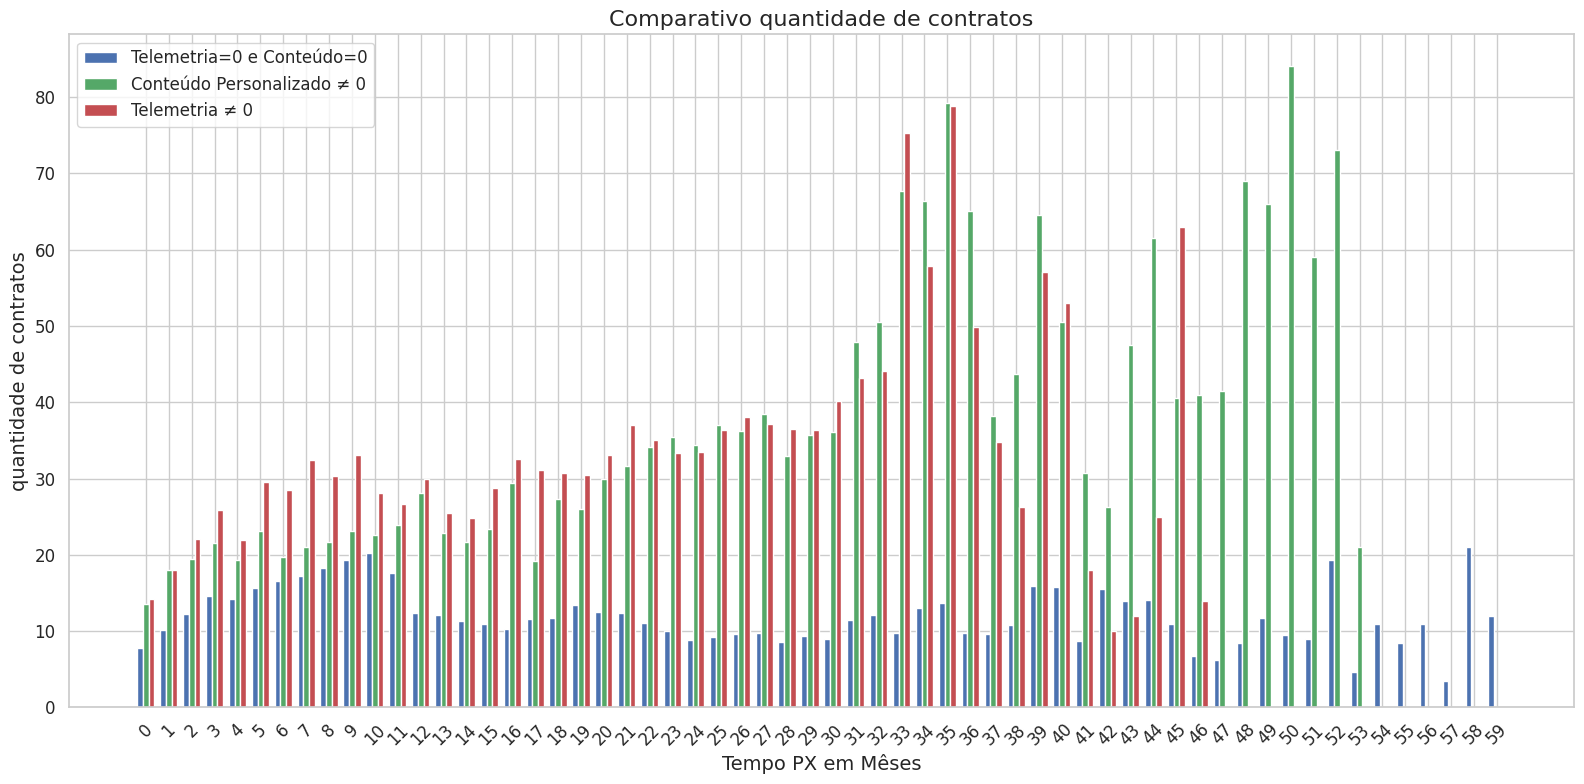

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Usar estilo do seaborn para melhorar a estética
sns.set(style="whitegrid")

# Primeiro DataFrame: Telemetria = 0 e Conteúdo Personalizado = 0
df1 = df_contratos.copy()
mask1 = (df1["Data Telemetria"] == 0) & (df1["Data Conteúdo Personalizado"] == 0)
df1 = df1[mask1]
df1["diff_days"] = (df1["diff_days"] / 31).astype(int)
df1 = df1.groupby(["company_id", "diff_days"])["min_date"].count().reset_index()
df1 = df1.groupby(["diff_days"])["min_date"].mean().reset_index()

# Segundo DataFrame: Conteúdo Personalizado != 0
df2 = df_contratos.copy()
mask2 = (df2["Data Conteúdo Personalizado"] != 0)
df2 = df2[mask2]
df2["diff_days"] = (df2["diff_days"] / 31).astype(int)
df2 = df2.groupby(["company_id", "diff_days"])["min_date"].count().reset_index()
df2 = df2.groupby(["diff_days"])["min_date"].mean().reset_index()

# Terceiro DataFrame: Telemetria != 0
df3 = df_contratos.copy()
mask3 = (df3["Data Telemetria"] != 0)
df3 = df3[mask3]
df3["diff_days"] = (df3["diff_days"] / 31).astype(int)
df3 = df3.groupby(["company_id", "diff_days"])["min_date"].count().reset_index()
df3 = df3.groupby(["diff_days"])["min_date"].mean().reset_index()

# Realizar merge dos DataFrames para alinhar os 'diff_days'
merged_df = df1.rename(columns={'min_date':'min_date_1'})
merged_df = merged_df.merge(df2.rename(columns={'min_date':'min_date_2'}), on='diff_days', how='outer')
merged_df = merged_df.merge(df3.rename(columns={'min_date':'min_date_3'}), on='diff_days', how='outer')
merged_df = merged_df.sort_values("diff_days").fillna(0)

# Definir posições para as barras
x = np.arange(len(merged_df['diff_days']))  
width = 0.25  # Largura de cada barra

# Criar figura maior para melhor visualização
fig, ax = plt.subplots(figsize=(16, 8))

# Plotar as barras agrupadas
ax.bar(x - width, merged_df['min_date_1'], width, label='Telemetria=0 e Conteúdo=0', color="#4c72b0")
ax.bar(x, merged_df['min_date_2'], width, label='Conteúdo Personalizado ≠ 0', color="#55a868")
ax.bar(x + width, merged_df['min_date_3'], width, label='Telemetria ≠ 0', color="#c44e52")

# Adicionar rótulos e título
ax.set_xlabel("Tempo PX em Mêses", fontsize=14)
ax.set_ylabel("quantidade de contratos", fontsize=14)
ax.set_title("Comparativo quantidade de contratos", fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(merged_df['diff_days'], fontsize=12, rotation=45)  # Rotaciona os labels
ax.tick_params(axis='y', labelsize=12)
ax.legend(fontsize=12)

plt.tight_layout()
plt.show()


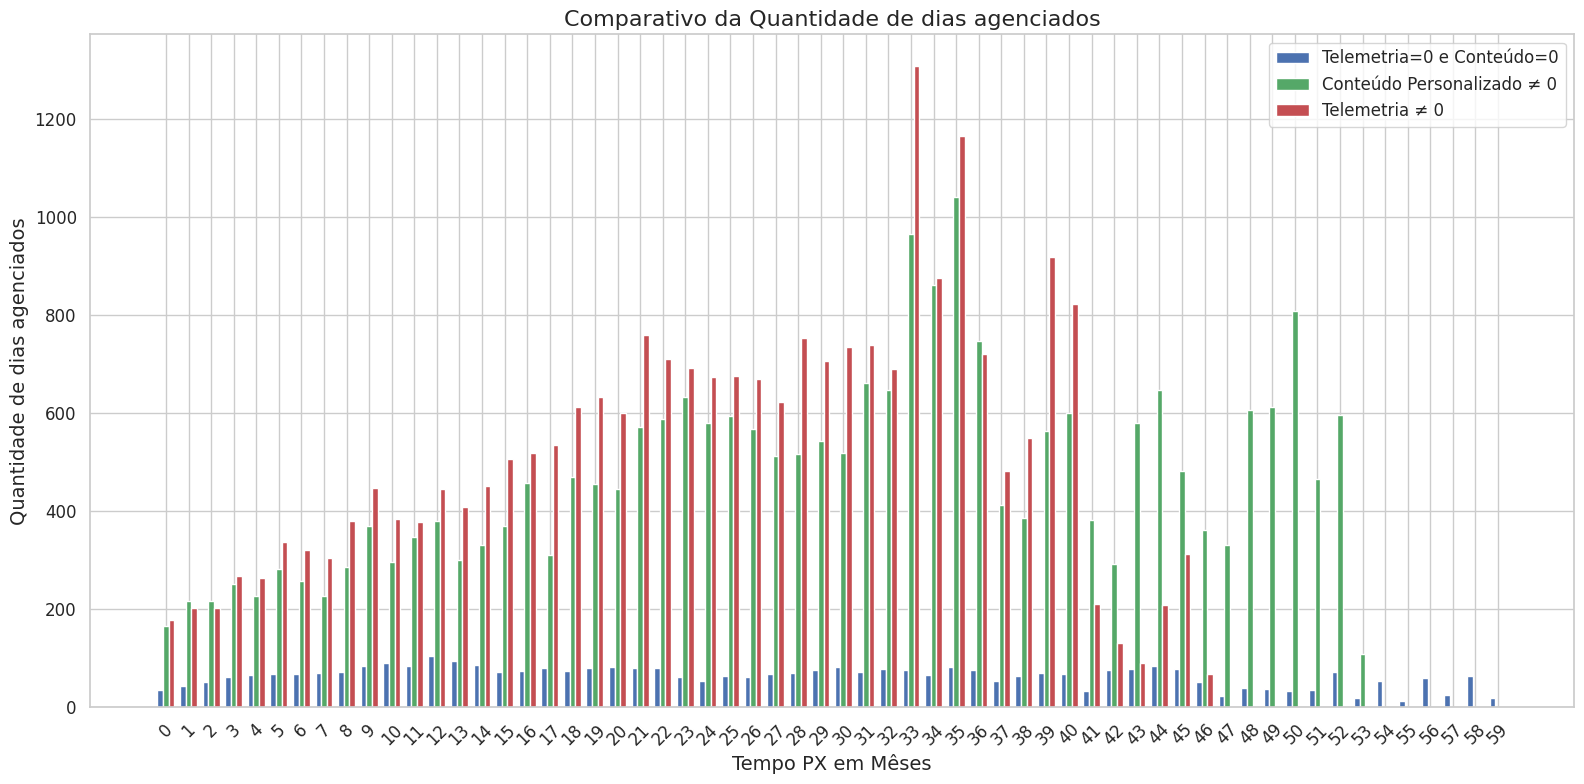

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Usar estilo do seaborn para melhorar a estética
sns.set(style="whitegrid")

# Primeiro DataFrame: Telemetria = 0 e Conteúdo Personalizado = 0
df1 = df_contratos.copy()
mask1 = (df1["Data Telemetria"] == 0) & (df1["Data Conteúdo Personalizado"] == 0)
df1 = df1[mask1]
df1["diff_days"] = (df1["diff_days"] / 31).astype(int)
df1 = df1.groupby(["company_id", "diff_days"])["contract_days"].sum().reset_index()
df1 = df1.groupby(["diff_days"])["contract_days"].mean().reset_index()

# Segundo DataFrame: Conteúdo Personalizado != 0
df2 = df_contratos.copy()
mask2 = (df2["Data Conteúdo Personalizado"] != 0)
df2 = df2[mask2]
df2["diff_days"] = (df2["diff_days"] / 31).astype(int)
df2 = df2.groupby(["company_id", "diff_days"])["contract_days"].sum().reset_index()
df2 = df2.groupby(["diff_days"])["contract_days"].mean().reset_index()

# Terceiro DataFrame: Telemetria != 0
df3 = df_contratos.copy()
mask3 = (df3["Data Telemetria"] != 0)
df3 = df3[mask3]
df3["diff_days"] = (df3["diff_days"] / 31).astype(int)
df3 = df3.groupby(["company_id", "diff_days"])["contract_days"].sum().reset_index()
df3 = df3.groupby(["diff_days"])["contract_days"].mean().reset_index()

# Realizar merge dos DataFrames para alinhar os 'diff_days'
merged_df = df1.rename(columns={'contract_days':'contract_days_1'})
merged_df = merged_df.merge(df2.rename(columns={'contract_days':'contract_days_2'}), on='diff_days', how='outer')
merged_df = merged_df.merge(df3.rename(columns={'contract_days':'contract_days_3'}), on='diff_days', how='outer')
merged_df = merged_df.sort_values("diff_days").fillna(0)

# Definir posições para as barras
x = np.arange(len(merged_df['diff_days']))  
width = 0.25  # Largura de cada barra

# Criar figura maior para melhor visualização
fig, ax = plt.subplots(figsize=(16, 8))

# Plotar as barras agrupadas
ax.bar(x - width, merged_df['contract_days_1'], width, label='Telemetria=0 e Conteúdo=0', color="#4c72b0")
ax.bar(x, merged_df['contract_days_2'], width, label='Conteúdo Personalizado ≠ 0', color="#55a868")
ax.bar(x + width, merged_df['contract_days_3'], width, label='Telemetria ≠ 0', color="#c44e52")

# Adicionar rótulos e título
ax.set_xlabel("Tempo PX em Mêses", fontsize=14)
ax.set_ylabel("Quantidade de dias agenciados", fontsize=14)
ax.set_title("Comparativo da Quantidade de dias agenciados", fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(merged_df['diff_days'], fontsize=12, rotation=45)
ax.tick_params(axis='y', labelsize=12)
ax.legend(fontsize=12)

plt.tight_layout()
plt.show()


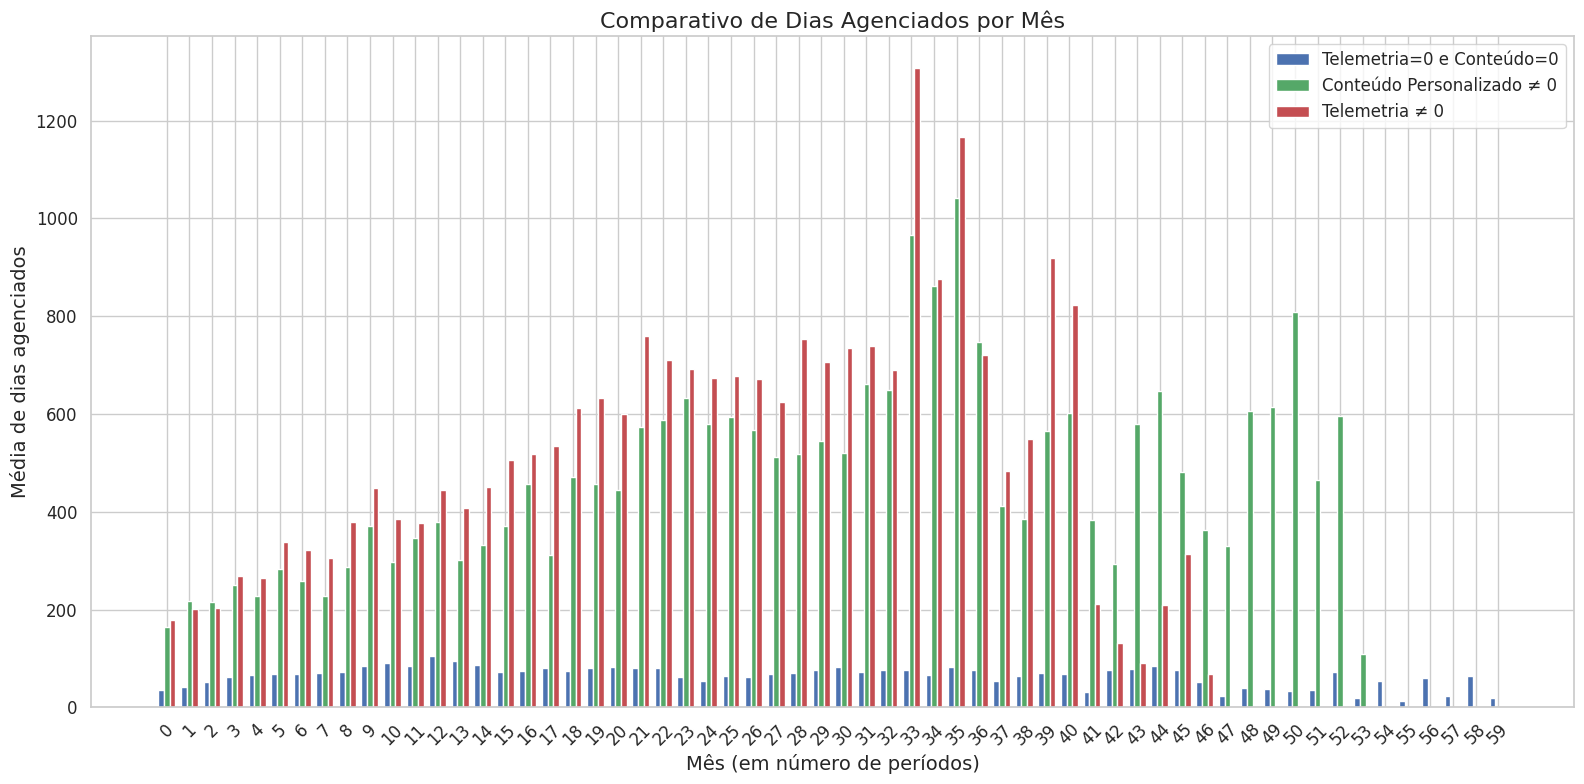

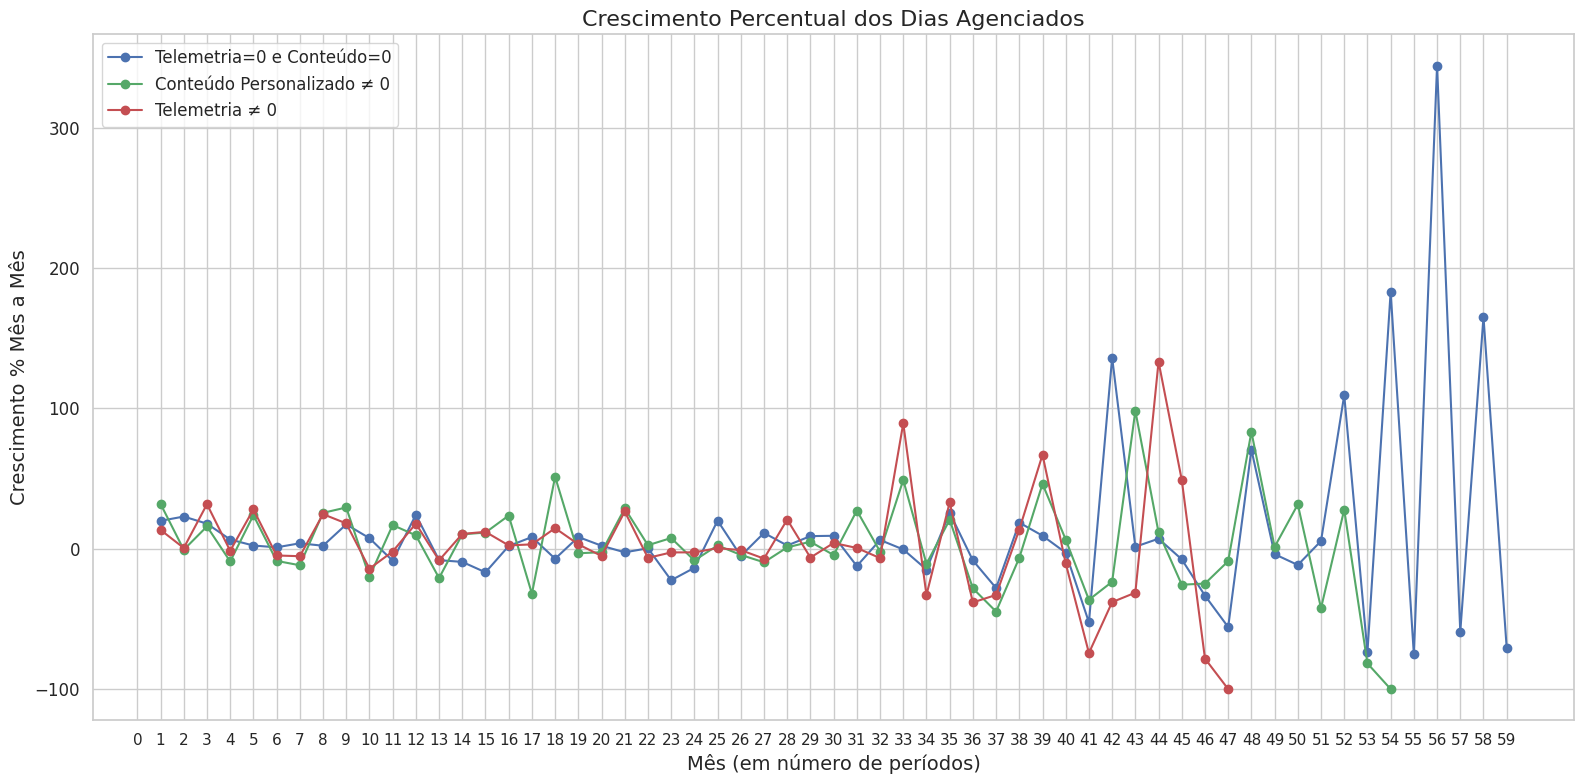

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Usar estilo do seaborn para melhorar a estética
sns.set(style="whitegrid")

# ================================
# Preparação dos DataFrames
# ================================

# 1. DataFrame: Telemetria = 0 e Conteúdo Personalizado = 0
df1 = df_contratos.copy()
mask1 = (df1["Data Telemetria"] == 0) & (df1["Data Conteúdo Personalizado"] == 0)
df1 = df1[mask1]
df1["diff_days"] = (df1["diff_days"] / 31).astype(int)
df1 = df1.groupby(["company_id", "diff_days"])["contract_days"].sum().reset_index()
df1 = df1.groupby(["diff_days"])["contract_days"].mean().reset_index()

# 2. DataFrame: Conteúdo Personalizado != 0
df2 = df_contratos.copy()
mask2 = (df2["Data Conteúdo Personalizado"] != 0)
df2 = df2[mask2]
df2["diff_days"] = (df2["diff_days"] / 31).astype(int)
df2 = df2.groupby(["company_id", "diff_days"])["contract_days"].sum().reset_index()
df2 = df2.groupby(["diff_days"])["contract_days"].mean().reset_index()

# 3. DataFrame: Telemetria != 0
df3 = df_contratos.copy()
mask3 = (df3["Data Telemetria"] != 0)
df3 = df3[mask3]
df3["diff_days"] = (df3["diff_days"] / 31).astype(int)
df3 = df3.groupby(["company_id", "diff_days"])["contract_days"].sum().reset_index()
df3 = df3.groupby(["diff_days"])["contract_days"].mean().reset_index()

# ================================
# Merge dos DataFrames
# ================================

merged_df = df1.rename(columns={'contract_days':'contract_days_1'})
merged_df = merged_df.merge(df2.rename(columns={'contract_days':'contract_days_2'}), on='diff_days', how='outer')
merged_df = merged_df.merge(df3.rename(columns={'contract_days':'contract_days_3'}), on='diff_days', how='outer')
merged_df = merged_df.sort_values("diff_days").fillna(0)

# ================================
# Gráfico de Barras: Valores Médios
# ================================

x = np.arange(len(merged_df['diff_days']))  
width = 0.25  # Largura de cada barra

fig, ax = plt.subplots(figsize=(16, 8))

ax.bar(x - width, merged_df['contract_days_1'], width, label='Telemetria=0 e Conteúdo=0', color="#4c72b0")
ax.bar(x, merged_df['contract_days_2'], width, label='Conteúdo Personalizado ≠ 0', color="#55a868")
ax.bar(x + width, merged_df['contract_days_3'], width, label='Telemetria ≠ 0', color="#c44e52")

ax.set_xlabel("Mês (em número de períodos)", fontsize=14)
ax.set_ylabel("Média de dias agenciados", fontsize=14)
ax.set_title("Comparativo de Dias Agenciados por Mês", fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(merged_df['diff_days'], fontsize=12, rotation=45)
ax.tick_params(axis='y', labelsize=12)
ax.legend(fontsize=12)

plt.tight_layout()
plt.show()

# ================================
# Cálculo do Crescimento Percentual Mês a Mês
# ================================

# Para cada série, calculamos a variação percentual em relação ao mês anterior
merged_df["growth_1"] = merged_df["contract_days_1"].pct_change() * 100
merged_df["growth_2"] = merged_df["contract_days_2"].pct_change() * 100
merged_df["growth_3"] = merged_df["contract_days_3"].pct_change() * 100

# ================================
# Gráfico de Linhas: Crescimento Percentual
# ================================

fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(merged_df['diff_days'], merged_df['growth_1'], marker='o', label='Telemetria=0 e Conteúdo=0', color="#4c72b0")
ax.plot(merged_df['diff_days'], merged_df['growth_2'], marker='o', label='Conteúdo Personalizado ≠ 0', color="#55a868")
ax.plot(merged_df['diff_days'], merged_df['growth_3'], marker='o', label='Telemetria ≠ 0', color="#c44e52")

ax.set_xlabel("Mês (em número de períodos)", fontsize=14)
ax.set_ylabel("Crescimento % Mês a Mês", fontsize=14)
ax.set_title("Crescimento Percentual dos Dias Agenciados", fontsize=16)
ax.set_xticks(merged_df['diff_days'])
ax.tick_params(axis='y', labelsize=12)
ax.legend(fontsize=12)
ax.grid(True)

plt.tight_layout()
plt.show()
